In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy.stats import spearmanr, ttest_ind
from tools import min_max_normalization, case_selection

from datetime import datetime

DATE = datetime.today().strftime("%Y-%m-%d")

In [2]:
PROXIES = {
    "MS.MIL.TOTL.TF.ZS": 1, # armed forces personnel
    "SH.H2O.SMDW.ZS": 0.5, # safely managed drinking water
}

YEARS = (2000, 2003, 2004, 2005, 2009, 2010, 2014)
SUCCESSFUL_TRANSITION = ("SRB", "UKR", "GEO")

In [3]:
def stateness_calculation(df, selected_cases=True):
    """ Adapted for the 'lowest common denominator'. """
    
    dataset = df.copy()
    dataset["proxy_weight"] = dataset["id"].map(PROXIES)
    dataset["norm"] = dataset.groupby(["year", "id"])["value"].transform(min_max_normalization)
    dataset["proxy_score"] = dataset["norm"] * dataset["proxy_weight"] 
    
    g = dataset.groupby(["year", "iso3"], as_index=False)["proxy_score"].sum()
    g["stateness"] = g["proxy_score"] / sum(PROXIES.values()) * 100
    g["successful_transition"] = g["iso3"].isin(SUCCESSFUL_TRANSITION).astype(int)
    result = g.drop("proxy_score", axis=1)
    result["approach"] = "lowest common denominator"
       
    return case_selection(result) if selected_cases else result

In [4]:
data = pd.read_excel("./../data/interim/world-bank-data_2020-05-27 22_30.xlsx")
df = data.loc[data["year"].isin(YEARS) & data["id"].isin(PROXIES.keys())].copy()

In [5]:
# show results for all countries
stateness_calculation(df, selected_cases=False)

,year,iso3,stateness,successful_transition,approach
0,2000,ARM,55.919948,0,lowest common denominator
1,2000,AZE,48.131108,0,lowest common denominator
2,2000,BLR,53.253884,0,lowest common denominator
3,2000,EST,45.339474,0,lowest common denominator
4,2000,GEO,45.126335,1,lowest common denominator
...,...,...,...,...,...
107,2014,SRB,28.246336,1,lowest common denominator
108,2014,TJK,5.176532,0,lowest common denominator
109,2014,TKM,51.506052,0,lowest common denominator
110,2014,UKR,41.827017,1,lowest common denominator


In [6]:
# show results for selected countries
stateness_calculation(df, selected_cases=True)

,year,iso3,stateness,successful_transition,approach
11,2000,SRB,90.186891,1,lowest common denominator
20,2003,GEO,42.121186,1,lowest common denominator
46,2004,UKR,31.951018,1,lowest common denominator
54,2005,KGZ,10.603574,0,lowest common denominator
73,2009,MDA,13.582207,0,lowest common denominator
86,2010,KGZ,14.582530,0,lowest common denominator
110,2014,UKR,41.827017,1,lowest common denominator


In [7]:
min_definition = stateness_calculation(df, selected_cases=True)
min_definition.to_excel(f"./../data/interim/min-definition_{DATE}.xlsx", index=False)

---

In [8]:
rcParams["font.size"] = 10
rcParams["figure.figsize"] = 16, 10

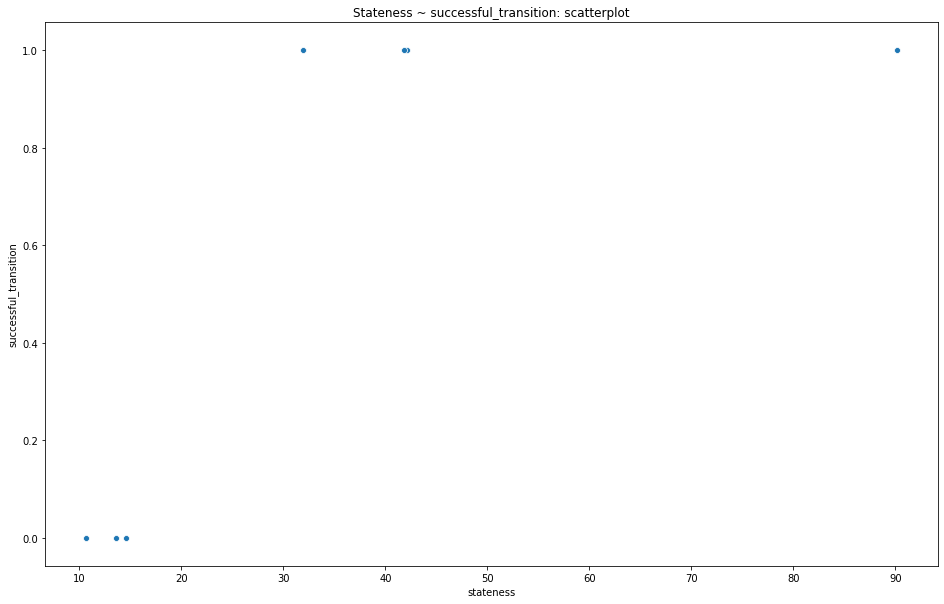

In [9]:
fig = sns.scatterplot(x="stateness", y="successful_transition", data=min_definition)
fig.set_title("Stateness ~ successful_transition: scatterplot")
plt.show()

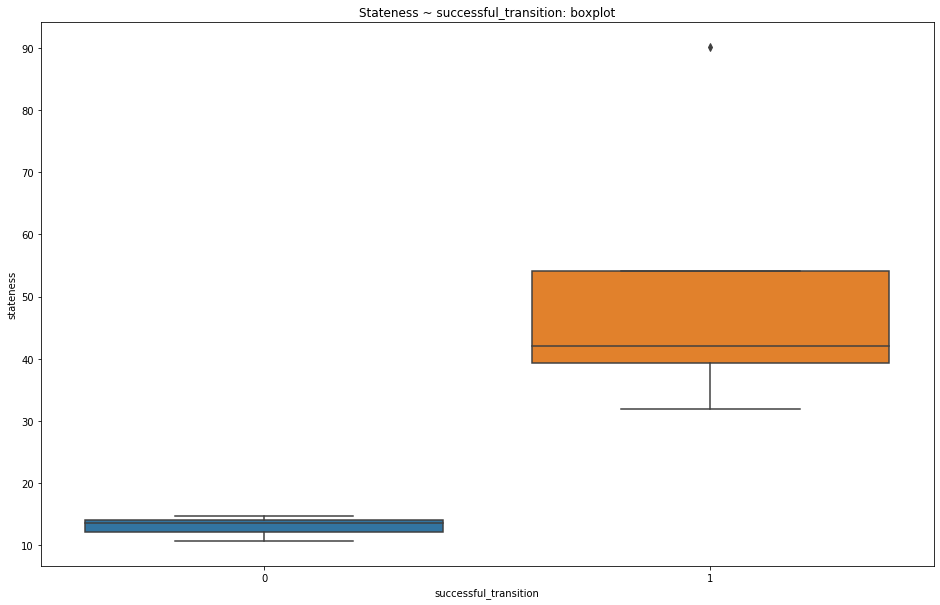

In [10]:
fig = sns.boxplot(x="successful_transition", y="stateness", data=min_definition)
fig.set_title("Stateness ~ successful_transition: boxplot")
plt.show()

In [11]:
statistic, pvalue = ttest_ind(min_definition["stateness"], min_definition["successful_transition"])

In [12]:
statistic

3.2789849776280158

In [13]:
pvalue

0.0065925135391564395

In [14]:
pvalue < 0.01

True